# Strategy 1 & 2: HYG Trading Strategies

Implementation of Strategy 1 and Strategy 2 based on BMOM (Blended Momentum) signals.

## Strategy 1 Logic:

```
thresh = -0.03

if (((SPY.BMOM(i-1) > thresh) && (SPY.BMOM(i) < thresh) && (HYG.BMOM(i) < thresh)) ||
    ((HYG.BMOM(i-1) > thresh) && (HYG.BMOM(i) < thresh) && (SPY.BMOM(i) < thresh))) &&
    (HYG.mom240(i) < 0)
    HYG_Strat1_Wgt = 0;
else
    if HYG.BMOM(i) > 0
        HYG_Strat1_Wgt = 1;
    else
        HYG_Strat1_Wgt(i) = HYG_Strat1_Wgt(i-1);
    end
end
```

## Strategy 2 Logic:

```
drawdiffthresh = 0.10

If (Strat1_drawdown - HYG_drawdown) > drawdiffthresh:
    HYG_Strat2_Wgt = 1  (override to long)
Else:
    Use same rules as Strat1 (signal = 0 or 1)
```

**Free Parameters:**
- w1, w2, w3, w4 (BMOM weights)
- thresh (threshold for exit)
- drawdiffthresh (drawdown differential threshold)
- mom240 length (momentum period for HYG in Strat1)

In [32]:
# =============================================================================
# IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Imports loaded")

Imports loaded


In [33]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Portfolio Constraints
CONSTRAINTS = {
    'Cash': {'min': 0.05, 'max': 0.10},
    'H5A4': {'min': 0.00, 'max': 0.12},  # HY capped at 12%
    'C5A0': {'min': 0.00, 'max': 0.95},
    'G5O2': {'min': 0.00, 'max': 0.95}
}

# Strategy 1: Signal Generation Thresholds (per asset)
SIGNAL_THRESHOLDS = {
    'H5A4': -0.03,   # Exit threshold vs SPY
    'C5A0': -0.013,  # Exit threshold vs LQD
    'G5O2': -0.01    # Exit threshold vs TLT
}

# Defensive Allocation (when no signals active)
DEFENSIVE_ALLOCATION = {'Cash': 0.10, 'H5A4': 0.00, 'C5A0': 0.00, 'G5O2': 0.90}

print("Configuration loaded")
print(f"\nSignal Thresholds:")
for asset, thresh in SIGNAL_THRESHOLDS.items():
    print(f"  {asset}: {thresh}")
print(f"\nDefensive Allocation: {DEFENSIVE_ALLOCATION}")
print(f"\nNote: Strategy 2 DD override thresholds are set in individual asset analysis files")

Configuration loaded

Signal Thresholds:
  H5A4: -0.03
  C5A0: -0.013
  G5O2: -0.01

Defensive Allocation: {'Cash': 0.1, 'H5A4': 0.0, 'C5A0': 0.0, 'G5O2': 0.9}

Note: Strategy 2 DD override thresholds are set in individual asset analysis files


In [34]:
# =============================================================================
# DATA LOADING
# =============================================================================

# Load ETF data from individual CSV files
spy_data = pd.read_csv(r'C:\Users\nimas\Regentfund Repository\fixed-income\Data Files\SPY 1.csv', 
                       parse_dates=['Date'], index_col='Date')
hyg_data = pd.read_csv(r'C:\Users\nimas\Regentfund Repository\fixed-income\Data Files\HYG.csv', 
                       skiprows=15, parse_dates=['Date'], index_col='Date', usecols=['Date', 'Price'])
lqd_data = pd.read_csv(r'C:\Users\nimas\Regentfund Repository\fixed-income\Data Files\LQD.csv', 
                       skiprows=15, parse_dates=['Date'], index_col='Date', usecols=['Date', 'Price'])
tlt_data = pd.read_csv(r'C:\Users\nimas\Regentfund Repository\fixed-income\Data Files\TLT.csv', 
                       skiprows=15, parse_dates=['Date'], index_col='Date', usecols=['Date', 'Price'])

# Load asset-specific data from CSV files
h5a4_data = pd.read_csv(r'C:\Users\nimas\Regentfund Repository\fixed-income\Data Files\H5A4.csv', 
                        parse_dates=['Date'], index_col='Date')
c5a0_data = pd.read_csv(r'C:\Users\nimas\Regentfund Repository\fixed-income\Data Files\C5A0.csv', 
                        parse_dates=['Date'], index_col='Date')
g5o2_data = pd.read_csv(r'C:\Users\nimas\Regentfund Repository\fixed-income\Data Files\G5O2.csv', 
                        parse_dates=['Date'], index_col='Date')

# Calculate BMOM for each asset (weighted momentum)
def calc_bmom(prices):
    return (0.15 * prices.pct_change(20) + 0.35 * prices.pct_change(60) + 
            0.35 * prices.pct_change(120) + 0.15 * prices.pct_change(240))

# Calculate benchmark BMOMs from ETF data
SPY_BMOM = calc_bmom(spy_data['SPY_adj_close'])
HYG_BMOM = calc_bmom(hyg_data['Price'])
LQD_BMOM = calc_bmom(lqd_data['Price'])
TLT_BMOM = calc_bmom(tlt_data['Price'])

# Calculate asset BMOMs and Mom240
H5A4_BMOM = calc_bmom(h5a4_data['H5A4'])
C5A0_BMOM = calc_bmom(c5a0_data['C5A0'])
G5O2_BMOM = calc_bmom(g5o2_data['G5O2'])

H5A4_Mom240 = h5a4_data['H5A4'].pct_change(240)
C5A0_Mom240 = c5a0_data['C5A0'].pct_change(240)
G5O2_Mom240 = g5o2_data['G5O2'].pct_change(240)

# Consolidate into single DataFrame
data = pd.DataFrame()

# Benchmark BMOMs
data['SPY_BMOM'] = SPY_BMOM
data['TLT_BMOM'] = TLT_BMOM
data['LQD_BMOM'] = LQD_BMOM
data['HYG_BMOM'] = HYG_BMOM

# Asset BMOMs
data['H5A4_BMOM'] = H5A4_BMOM
data['C5A0_BMOM'] = C5A0_BMOM
data['G5O2_BMOM'] = G5O2_BMOM

# Asset Prices
data['H5A4_Price'] = h5a4_data['H5A4']
data['C5A0_Price'] = c5a0_data['C5A0']
data['G5O2_Price'] = g5o2_data['G5O2']

# Mom240 (240-day momentum for exit filter)
data['H5A4_Mom240'] = H5A4_Mom240
data['C5A0_Mom240'] = C5A0_Mom240
data['G5O2_Mom240'] = G5O2_Mom240

# Sort and clean
data = data.sort_index()
data.index = pd.to_datetime(data.index)
data.index.name = 'Date'

# Filter to first common date (no NaN in core columns)
core_cols = ['SPY_BMOM', 'TLT_BMOM', 'LQD_BMOM', 'HYG_BMOM', 
             'H5A4_BMOM', 'C5A0_BMOM', 'G5O2_BMOM',
             'H5A4_Price', 'C5A0_Price', 'G5O2_Price', 
             'H5A4_Mom240', 'C5A0_Mom240', 'G5O2_Mom240']
first_date = data[core_cols].dropna().index.min()
data = data.loc[first_date:].copy()

# Calculate daily returns
data['H5A4_Return'] = data['H5A4_Price'].pct_change()
data['C5A0_Return'] = data['C5A0_Price'].pct_change()
data['G5O2_Return'] = data['G5O2_Price'].pct_change()

print(f"Data loaded successfully")
print(f"  Shape: {data.shape}")
print(f"  Date range: {data.index.min().date()} to {data.index.max().date()}")
print(f"  Trading days: {len(data):,}")

Data loaded successfully
  Shape: (4439, 16)
  Date range: 2008-03-25 to 2025-11-11
  Trading days: 4,439


In [35]:
# =============================================================================
# STRATEGY 1 SIGNAL GENERATION
# =============================================================================
# Generate Strategy 1 signals for each asset
# Each asset uses its corresponding ETF benchmark as regime filter:
# - H5A4 uses SPY (threshold = -0.03)
# - C5A0 uses LQD (threshold = -0.013)
# - G5O2 uses TLT (threshold = -0.01)
# PLUS mom240 < 0 filter added to exit condition

def generate_strategy1_signals(asset_bmom, benchmark_bmom, asset_mom240, threshold):
    """
    Generate Strategy 1 signals with cross-asset momentum and benchmark regime filter.
    
    Exit (signal=0): (Benchmark or Asset crosses below threshold while both are below threshold) AND (asset mom240 < 0)
    Entry (signal=1): Asset BMOM > 0
    Hold: Keep previous signal
    """
    signals = pd.Series(0, index=asset_bmom.index)
    
    for i in range(1, len(asset_bmom)):
        # Current values
        bench_curr = benchmark_bmom.iloc[i]
        asset_curr = asset_bmom.iloc[i]
        mom240_curr = asset_mom240.iloc[i]
        
        # Previous values
        bench_prev = benchmark_bmom.iloc[i-1]
        asset_prev = asset_bmom.iloc[i-1]
        
        # Exit Condition 1: Benchmark crosses below threshold while both below threshold
        cond1 = (bench_prev > threshold) and (bench_curr < threshold) and (asset_curr < threshold)
        
        # Exit Condition 2: Asset crosses below threshold while both below threshold
        cond2 = (asset_prev > threshold) and (bench_curr < threshold) and (asset_curr < threshold)
        
        # Additional condition: Asset mom240 must be negative
        mom240_negative = mom240_curr < 0
        
        if (cond1 or cond2) and mom240_negative:
            # Exit - set signal to 0 (only if mom240 < 0)
            signals.iloc[i] = 0
        elif asset_curr > 0:
            # Entry - asset has positive momentum
            signals.iloc[i] = 1
        else:
            # Hold - keep previous signal
            signals.iloc[i] = signals.iloc[i-1]
    
    return signals

# Asset-specific thresholds (using SIGNAL_THRESHOLDS from configuration)
THRESHOLDS = {
    'H5A4': SIGNAL_THRESHOLDS['H5A4'],
    'C5A0': SIGNAL_THRESHOLDS['C5A0'],
    'G5O2': SIGNAL_THRESHOLDS['G5O2']
}

# Generate signals for each asset with its corresponding benchmark, mom240, and threshold
signals = pd.DataFrame(index=data.index)
signals['H5A4'] = generate_strategy1_signals(data['H5A4_BMOM'], data['SPY_BMOM'], data['H5A4_Mom240'], THRESHOLDS['H5A4'])
signals['C5A0'] = generate_strategy1_signals(data['C5A0_BMOM'], data['LQD_BMOM'], data['C5A0_Mom240'], THRESHOLDS['C5A0'])
signals['G5O2'] = generate_strategy1_signals(data['G5O2_BMOM'], data['TLT_BMOM'], data['G5O2_Mom240'], THRESHOLDS['G5O2'])

# Signal distribution summary
print("Strategy 1 Signal Distribution (with mom240 filter):")
print("="*60)
print("Asset    Benchmark    Threshold    Long %    Flat %")
print("-"*60)
for asset, bench in [('H5A4', 'SPY'), ('C5A0', 'LQD'), ('G5O2', 'TLT')]:
    long_pct = signals[asset].mean() * 100
    thresh = THRESHOLDS[asset]
    print(f"{asset}     {bench}          {thresh:>7.3f}     {long_pct:>5.1f}%    {100-long_pct:>5.1f}%")

print(f"\nTotal days: {len(signals)}")
print(f"Date range: {signals.index.min()} to {signals.index.max()}")

Strategy 1 Signal Distribution (with mom240 filter):
Asset    Benchmark    Threshold    Long %    Flat %
------------------------------------------------------------
H5A4     SPY           -0.030      82.2%     17.8%
C5A0     LQD           -0.013      68.0%     32.0%
G5O2     TLT           -0.010      65.4%     34.6%

Total days: 4439
Date range: 2008-03-25 00:00:00 to 2025-11-11 00:00:00


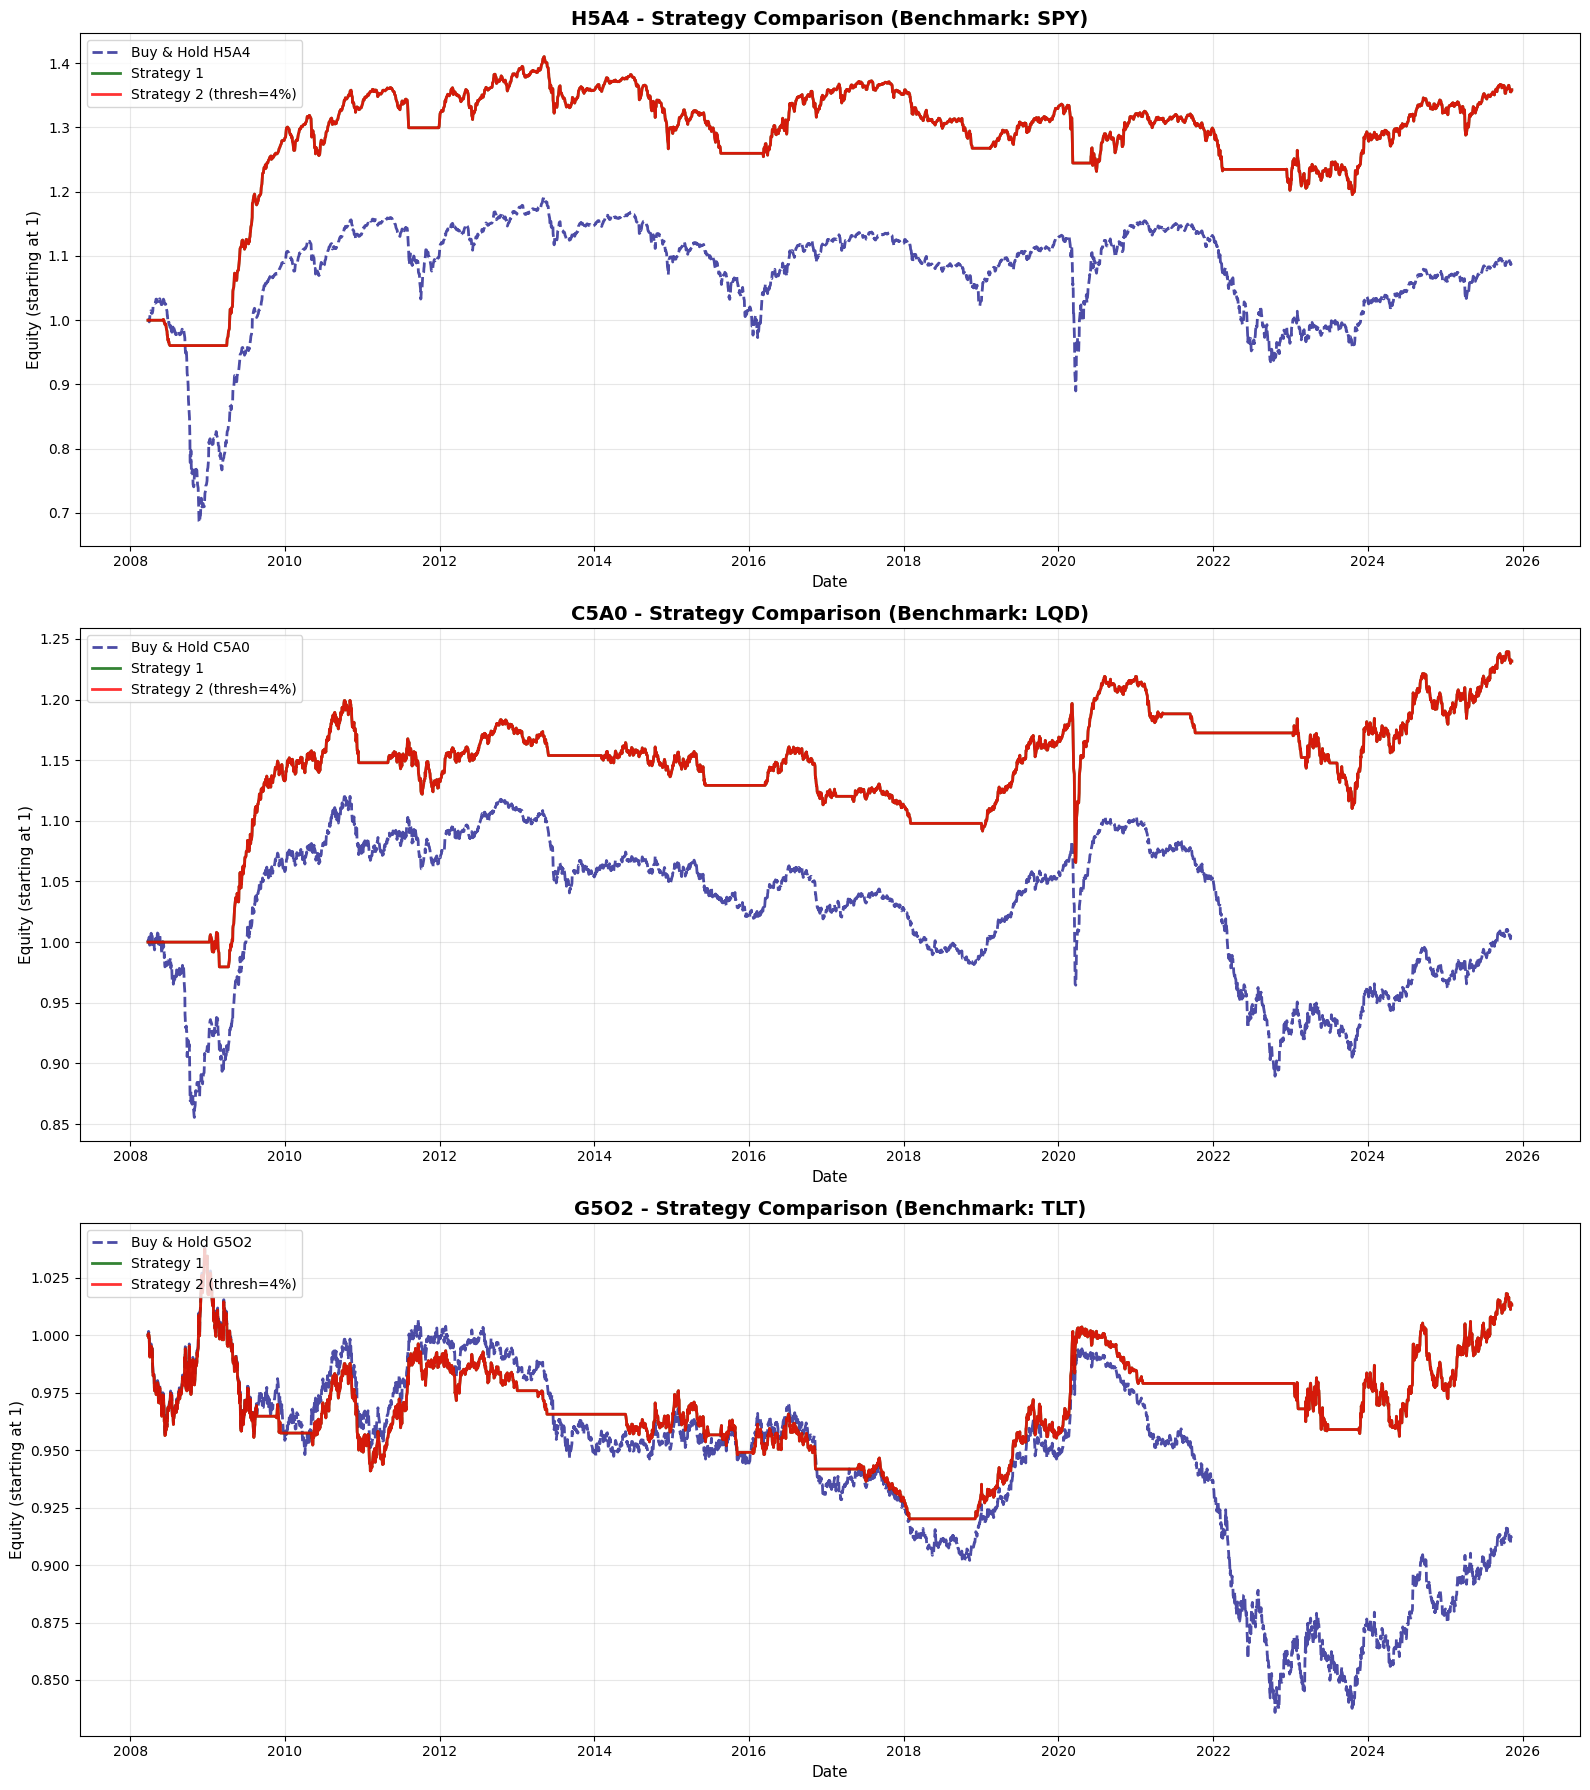


Strategy 2 Threshold: 4%
PERFORMANCE SUMMARY - ALL ASSETS

H5A4 (Benchmark: SPY)
----------------------------------------------------------------------
Strategy                    Ann Return   Volatility     Sharpe
----------------------------------------------------------------------
Buy & Hold                      0.49%       5.51%      0.12
Strategy 1                      1.76%       3.27%      0.55
Strategy 2                      1.76%       3.27%      0.55

C5A0 (Benchmark: LQD)
----------------------------------------------------------------------
Strategy                    Ann Return   Volatility     Sharpe
----------------------------------------------------------------------
Buy & Hold                      0.02%       3.75%      0.03
Strategy 1                      1.19%       2.82%      0.43
Strategy 2                      1.19%       2.82%      0.43

G5O2 (Benchmark: TLT)
----------------------------------------------------------------------
Strategy                    Ann

In [36]:
# =============================================================================
# STRATEGY 2 SIGNAL GENERATION - DRAWDOWN DIFFERENTIAL OVERRIDE
# =============================================================================
# Strategy 2 adds a drawdown differential override to Strategy 1:
# - If (Strat1_drawdown - BuyHold_drawdown) > threshold: override to long
# - Exit override when Strategy 1 signal returns to 1
# - Otherwise follow Strategy 1

import matplotlib.dates as mdates

# =============================================================================
# CONFIGURATION - SELECT THRESHOLD HERE
# =============================================================================
STRAT2_THRESHOLD = 0.044  # Change this value to adjust the drawdown differential threshold

# List of assets and their benchmarks
ASSETS = ['H5A4', 'C5A0', 'G5O2']
BENCHMARKS = {'H5A4': 'SPY', 'C5A0': 'LQD', 'G5O2': 'TLT'}

# =============================================================================
# STEP 1: Calculate Strategy 1 Returns, Equity Curves, and Drawdowns
# =============================================================================

strat1_returns = {}
strat1_equity = {}
strat1_drawdown = {}
strat1_metrics = {}

buyhold_equity = {}
buyhold_drawdown = {}
buyhold_metrics = {}

for asset in ASSETS:
    daily_ret = data[f'{asset}_Return'].fillna(0)
    
    strat1_ret = daily_ret * signals[asset].shift(1)
    strat1_ret = strat1_ret.fillna(0)
    strat1_returns[asset] = strat1_ret
    
    strat1_eq = (1 + strat1_ret).cumprod()
    strat1_equity[asset] = strat1_eq
    
    strat1_dd = 1 - strat1_eq / strat1_eq.cummax()
    strat1_drawdown[asset] = strat1_dd
    
    strat1_vol = strat1_ret.std() * np.sqrt(252)
    strat1_sharpe = (strat1_ret.mean() / strat1_ret.std()) * np.sqrt(252) if strat1_ret.std() > 0 else 0
    strat1_ann_ret = strat1_eq.iloc[-1] ** (252 / len(strat1_eq)) - 1
    strat1_metrics[asset] = {'ann_return': strat1_ann_ret, 'volatility': strat1_vol, 'sharpe': strat1_sharpe}
    
    buyhold_eq = (1 + daily_ret).cumprod()
    buyhold_equity[asset] = buyhold_eq
    
    buyhold_dd = 1 - buyhold_eq / buyhold_eq.cummax()
    buyhold_drawdown[asset] = buyhold_dd
    
    buyhold_vol = daily_ret.std() * np.sqrt(252)
    buyhold_sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() > 0 else 0
    buyhold_ann_ret = buyhold_eq.iloc[-1] ** (252 / len(buyhold_eq)) - 1
    buyhold_metrics[asset] = {'ann_return': buyhold_ann_ret, 'volatility': buyhold_vol, 'sharpe': buyhold_sharpe}

# =============================================================================
# STEP 2: Calculate Drawdown Differentials
# =============================================================================

drawdown_diff = {}
for asset in ASSETS:
    drawdown_diff[asset] = strat1_drawdown[asset] - buyhold_drawdown[asset]

# =============================================================================
# STEP 3: Generate Strategy 2 Signals
# =============================================================================

def generate_strategy2_signals(strat1_signals, dd_diff, threshold):
    strat2_signals = strat1_signals.copy()
    in_override = False
    
    for i in range(len(strat1_signals)):
        strat1_sig = strat1_signals.iloc[i]
        dd_diff_val = dd_diff.iloc[i]
        
        if dd_diff_val > threshold:
            strat2_signals.iloc[i] = 1
            in_override = True
        elif in_override and strat1_sig == 1:
            strat2_signals.iloc[i] = strat1_sig
            in_override = False
        elif in_override:
            strat2_signals.iloc[i] = 1
        else:
            strat2_signals.iloc[i] = strat1_sig
    
    return strat2_signals

strat2_signals = pd.DataFrame(index=data.index)
strat2_returns = {}
strat2_equity = {}
strat2_metrics = {}

for asset in ASSETS:
    daily_ret = data[f'{asset}_Return'].fillna(0)
    
    strat2_sig = generate_strategy2_signals(signals[asset], drawdown_diff[asset], STRAT2_THRESHOLD)
    strat2_signals[asset] = strat2_sig
    
    strat2_ret = daily_ret * strat2_sig.shift(1)
    strat2_ret = strat2_ret.fillna(0)
    strat2_returns[asset] = strat2_ret
    
    strat2_eq = (1 + strat2_ret).cumprod()
    strat2_equity[asset] = strat2_eq
    
    strat2_vol = strat2_ret.std() * np.sqrt(252)
    strat2_sharpe = (strat2_ret.mean() / strat2_ret.std()) * np.sqrt(252) if strat2_ret.std() > 0 else 0
    strat2_ann_ret = strat2_eq.iloc[-1] ** (252 / len(strat2_eq)) - 1
    
    strat2_metrics[asset] = {'ann_return': strat2_ann_ret, 'volatility': strat2_vol, 'sharpe': strat2_sharpe}

# =============================================================================
# STEP 4: Plot Equity Curves
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(16, 18))

for idx, asset in enumerate(ASSETS):
    ax = axes[idx]
    ax.plot(data.index, buyhold_equity[asset], linewidth=2.0, color='navy', 
            label=f'Buy & Hold {asset}', linestyle='--', alpha=0.7)
    ax.plot(data.index, strat1_equity[asset], linewidth=2.0, color='darkgreen', 
            label='Strategy 1', alpha=0.8)
    ax.plot(data.index, strat2_equity[asset], linewidth=2.0, color='red', 
            label=f'Strategy 2 (thresh={STRAT2_THRESHOLD:.0%})', alpha=0.8)
    
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_title(f'{asset} - Strategy Comparison (Benchmark: {BENCHMARKS[asset]})', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Equity (starting at 1)', fontsize=11)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 5: Performance Summary
# =============================================================================

print(f"\nStrategy 2 Threshold: {STRAT2_THRESHOLD:.0%}")
print("="*80)
print("PERFORMANCE SUMMARY - ALL ASSETS")
print("="*80)

for asset in ASSETS:
    print(f"\n{asset} (Benchmark: {BENCHMARKS[asset]})")
    print("-"*70)
    print(f"{'Strategy':<25} {'Ann Return':>12} {'Volatility':>12} {'Sharpe':>10}")
    print("-"*70)
    
    bm = buyhold_metrics[asset]
    print(f"{'Buy & Hold':<25} {bm['ann_return']:>11.2%} {bm['volatility']:>11.2%} {bm['sharpe']:>9.2f}")
    
    s1 = strat1_metrics[asset]
    print(f"{'Strategy 1':<25} {s1['ann_return']:>11.2%} {s1['volatility']:>11.2%} {s1['sharpe']:>9.2f}")
    
    s2 = strat2_metrics[asset]
    print(f"{'Strategy 2':<25} {s2['ann_return']:>11.2%} {s2['volatility']:>11.2%} {s2['sharpe']:>9.2f}")

print(f"\n" + "="*80)
print("STRATEGY 2 SIGNAL SUMMARY")
print("="*80)
for asset in ASSETS:
    s1_long = signals[asset].mean() * 100
    s2_long = strat2_signals[asset].mean() * 100
    diff_days = (strat2_signals[asset] != signals[asset]).sum()
    print(f"{asset}: Strat1 Long {s1_long:.1f}% | Strat2 Long {s2_long:.1f}% | Override days: {diff_days}")

print(f"\nDate range: {data.index.min().date()} to {data.index.max().date()}")
print(f"Total trading days: {len(data):,}")

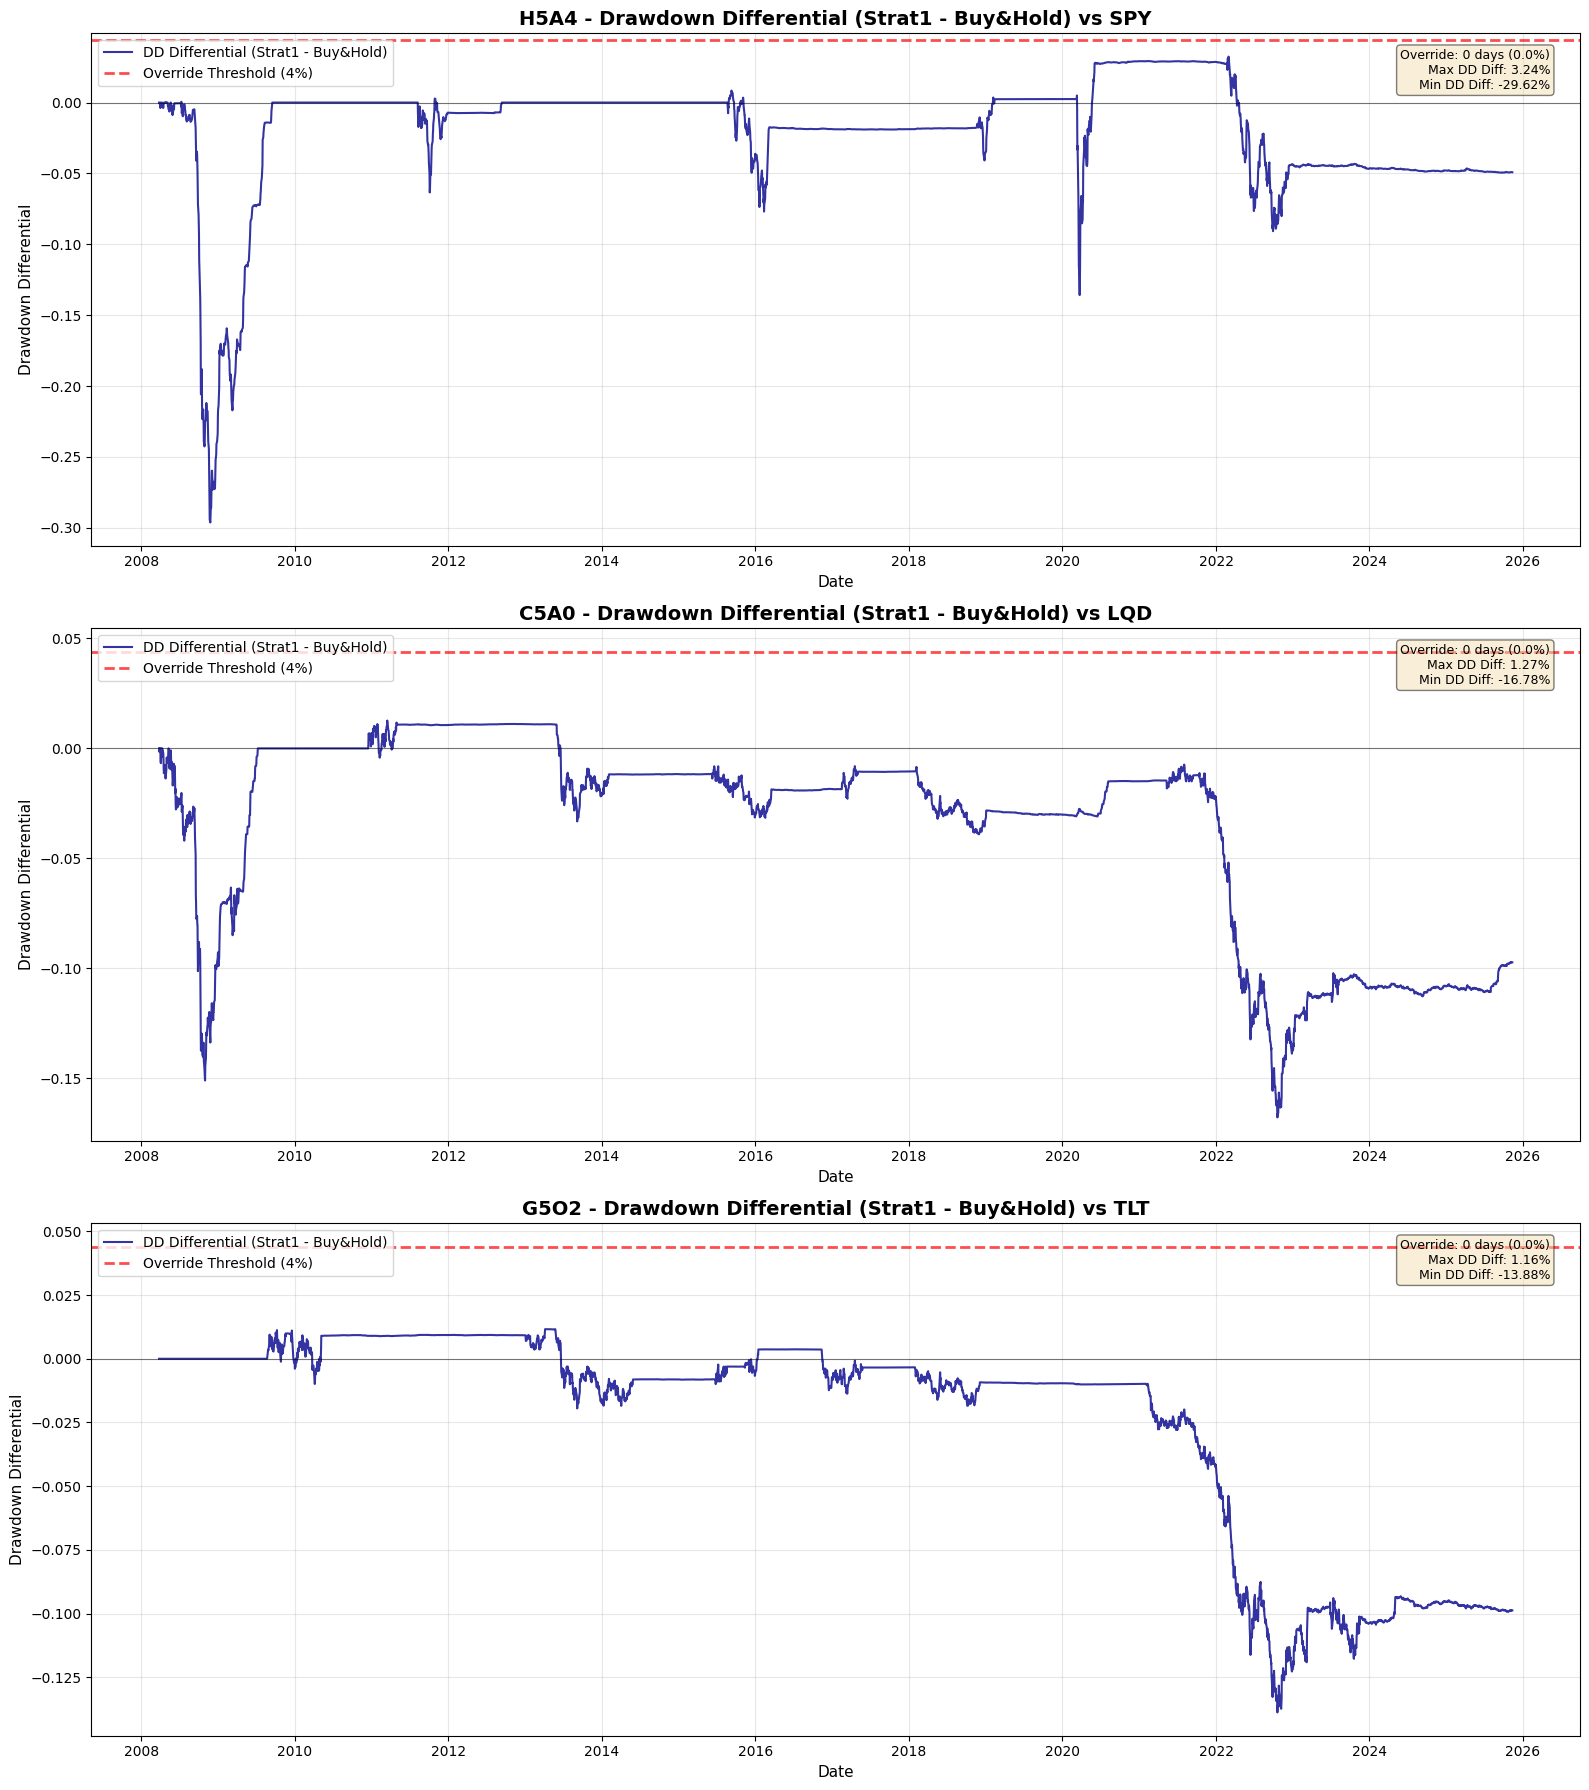


OVERRIDE PERIOD DETAILS

H5A4:
  Total override periods: 0
  Total override days: 0 (0.0%)

C5A0:
  Total override periods: 0
  Total override days: 0 (0.0%)

G5O2:
  Total override periods: 0
  Total override days: 0 (0.0%)


In [37]:
# =============================================================================
# # DRAWDOWN DIFFERENTIAL VISUALIZATION WITH OVERRIDE PERIODS
# # =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(16, 18))

for idx, asset in enumerate(ASSETS):
    ax = axes[idx]

    # Plot drawdown differential
    ax.plot(data.index, drawdown_diff[asset], linewidth=1.5, color='darkblue',
            label='DD Differential (Strat1 - Buy&Hold)', alpha=0.8)

    # Add threshold line
    ax.axhline(y=STRAT2_THRESHOLD, color='red', linestyle='--', linewidth=2,
                label=f'Override Threshold ({STRAT2_THRESHOLD:.0%})', alpha=0.7)

    # Add zero line for reference
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

    # Highlight override periods (where Strat2 differs from Strat1)
    override_active = (strat2_signals[asset] != signals[asset])

    # Find contiguous override periods
    override_change = override_active.astype(int).diff()
    starts = data.index[override_change == 1].tolist()
    ends = data.index[override_change == -1].tolist()

    # Handle edge cases
    if override_active.iloc[0]:
        starts.insert(0, data.index[0])
    if override_active.iloc[-1]:
        ends.append(data.index[-1])

    # Shade override periods
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, alpha=0.2, color='red', label='_nolegend_')

    # Add single legend entry for override periods
    if len(starts) > 0:
        ax.axvspan(data.index[0], data.index[0], alpha=0.2, color='red',
                    label=f'Override Active ({len(starts)} periods)')

    # Formatting
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_title(f'{asset} - Drawdown Differential (Strat1 - Buy&Hold) vs {BENCHMARKS[asset]}',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Drawdown Differential', fontsize=11)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Add statistics text box
    override_days = override_active.sum()
    total_days = len(override_active)
    override_pct = (override_days / total_days) * 100
    max_dd_diff = drawdown_diff[asset].max()
    min_dd_diff = drawdown_diff[asset].min()

    stats_text = f'Override: {override_days} days ({override_pct:.1f}%)\n'
    stats_text += f'Max DD Diff: {max_dd_diff:.2%}\n'
    stats_text += f'Min DD Diff: {min_dd_diff:.2%}'

    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print override period details
print("\nOVERRIDE PERIOD DETAILS")
print("="*80)
for asset in ASSETS:
    print(f"\n{asset}:")
    override_active = (strat2_signals[asset] != signals[asset])
    override_change = override_active.astype(int).diff()
    starts = data.index[override_change == 1].tolist()
    ends = data.index[override_change == -1].tolist()

    if override_active.iloc[0]:
        starts.insert(0, data.index[0])
    if override_active.iloc[-1]:
        ends.append(data.index[-1])

    print(f"  Total override periods: {len(starts)}")
    print(f"  Total override days: {override_active.sum()} ({override_active.mean()*100:.1f}%)")

    if len(starts) > 0:
        print(f"\n  {'Start Date':<15} {'End Date':<15} {'Days':>8} {'Max DD Diff':>12}")
        print(f"  {'-'*60}")
        for start, end in zip(starts, ends):
            period_mask = (data.index >= start) & (data.index <= end)
            period_days = period_mask.sum()
            max_dd_in_period = drawdown_diff[asset][period_mask].max()
            print(f"  {start.date()} {end.date()}  {period_days:>7}  {max_dd_in_period:>11.2%}")